In [2]:
library(Seurat)
library(dplyr)
library(patchwork)
library(harmony)
library(future)
library(ggplot2)
library(trqwe)
library(unix)
library(readr)
library(reshape2)
library(rmcorr)
library(pheatmap)
library(dplyr)
library(Seurat)
library(data.table)
source("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/scripts/functions/glmm_functions_4.R")

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Warning message:
“package ‘readr’ was built under R version 4.1.3”

Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
setwd("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/DA/")

In [4]:
data<-mcreadRDS("../all_compartments_qc.rds",mc.core=4)

In [5]:
data

An object of class Seurat 
32913 features across 580040 samples within 1 assay 
Active assay: RNA (32913 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 7 dimensional reductions calculated: pca_RNA, umapBeforeHarmony_RNA, harmony_RNA, umapAfterHarmony_RNA, pca, harmony, umap_harmony_new

In [77]:
unique(data@meta.data$level_1)
unique(data@meta.data$level_2)

[1] "monocyte" "T reg"    "DC"       "T CD4+"   "NK"       "T CD8+"  
 [7] "RBC"      "B"        "MAIT"     "T g/d"    "B_ASC"    "Platelet"
[13] "HSPC"

[1] "CD14mono"           "T reg"              "CD16mono"          
 [4] "pDC"                "T CD4 Naive"        "NK"                
 [7] "T CD4 Helper"       "T CD8 CTL"          "Int.mono"          
[10] "T CD4 CTL"          "RBC"                "B_ASC_dividing"    
[13] "B_switched_mem"     "NK CD56 bright"     "T CD8 Naive"       
[16] "DC2"                "MAIT"               "T g/d"             
[19] "B_naive"            "NKT"                "T CD8 Mem"         
[22] "B_ASC_IgA"          "Platelet"           "HSPC"              
[25] "B_ASC_IgM"          "B_non-switched_mem" "DC3"               
[28] "B_ASC_IgG"          "DC1"                "T CD4 cycling"     
[31] "B_CD11c"            "T CD8 EMRA"         "ILC"               
[34] "ASDC"               "B_ASC_other"

In [78]:
#######################
# Case Control Orexin pathway
#######################

In [79]:
"case_control"%in%names(data@meta.data)

[1] TRUE

In [80]:
data1<-subset(data,subset=case_control!="RECOVERY" & level_1%in%c("monocyte","NK","DC"))

In [14]:
#add new group
data1@meta.data[data1@meta.data$case_control=="POSITIVE" & data1@meta.data$level_1=="monocyte", "level_1_case_control"]<-"monocyte_positive"
data1@meta.data[data1@meta.data$case_control=="NEGATIVE" & data1@meta.data$level_1=="monocyte", "level_1_case_control"]<-"monocyte_negative"
data1@meta.data[data1@meta.data$case_control=="POSITIVE" & data1@meta.data$level_1=="NK", "level_1_case_control"]<-"NK_positive"
data1@meta.data[data1@meta.data$case_control=="NEGATIVE" & data1@meta.data$level_1=="NK", "level_1_case_control"]<-"NK_negative"
data1@meta.data[data1@meta.data$case_control=="POSITIVE" & data1@meta.data$level_1=="DC", "level_1_case_control"]<-"DC_positive"
data1@meta.data[data1@meta.data$case_control=="NEGATIVE" & data1@meta.data$level_1=="DC", "level_1_case_control"]<-"DC_negative"




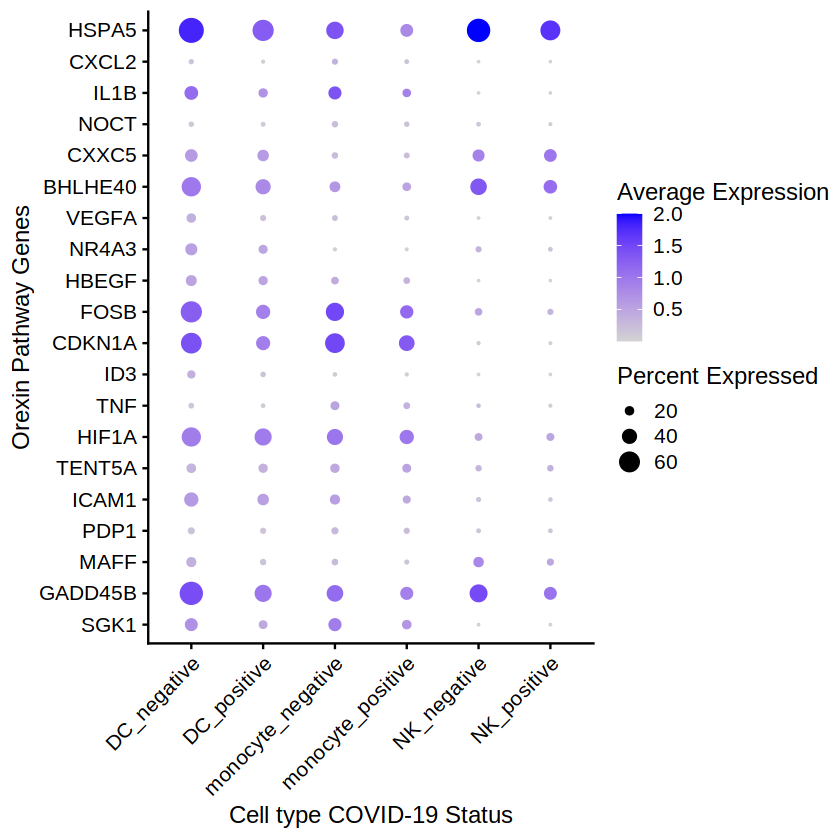

In [20]:
DotPlot(data1,
        features=c("SGK1","GADD45B","MAFF","PDP1","ICAM1","TENT5A","HIF1A","TNF","ID3","CDKN1A","FOSB","HBEGF","NR4A3","VEGFA","BHLHE40","CXXC5","NOCT","IL1B","CXCL2","HSPA5"),
        group.by="level_1_case_control") +
coord_flip() +
ylab("Cell type COVID-19 Status") +
xlab("Orexin Pathway Genes") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave("multiple_cell_types_orexin_pathway_case_control_dot_plot.pdf",height=6,width=5)


In [41]:
######################
# Severity Monocytes Level 1
######################

In [42]:
data1<-subset(data,subset=level_1=="monocyte")

In [43]:
"WHO_temp_severity"%in%names(data1@meta.data)
"WHO_temp_severity_group"%in%names(data1@meta.data)

[1] TRUE

[1] FALSE

In [44]:
data1@meta.data[!is.na(data1@meta.data$WHO_temp_severity) & data1@meta.data$WHO_temp_severity=="mild", "WHO_temp_severity_group"]<-"mild_moderate"
data1@meta.data[!is.na(data1@meta.data$WHO_temp_severity) & data1@meta.data$WHO_temp_severity=="moderate", "WHO_temp_severity_group"]<-"mild_moderate"
data1@meta.data[!is.na(data1@meta.data$WHO_temp_severity) & data1@meta.data$WHO_temp_severity=="severe", "WHO_temp_severity_group"]<-"severe_critical"
data1@meta.data[!is.na(data1@meta.data$WHO_temp_severity) & data1@meta.data$WHO_temp_severity=="critical", "WHO_temp_severity_group"]<-"severe_critical"
data1@meta.data[is.na(data1@meta.data$WHO_temp_severity), "WHO_temp_severity_group"]<-"NA"


In [47]:
table(data1@meta.data$WHO_temp_severity,useNA="always")
table(data1@meta.data$WHO_temp_severity_group,useNA="always")


critical     mild moderate   severe     <NA> 
    7135    37044    12032     3696    35121 


  mild_moderate              NA severe_critical            <NA> 
          49076           35121           10831               0 

In [53]:
"individual_id"%in%names(data2@meta.data)

[1] TRUE

In [54]:
"C139"%in%data2@meta.data$individual_id
"C116"%in%data2@meta.data$individual_id

[1] FALSE

[1] FALSE

In [52]:
data2<-subset(data1,subset=WHO_temp_severity_group!="NA")

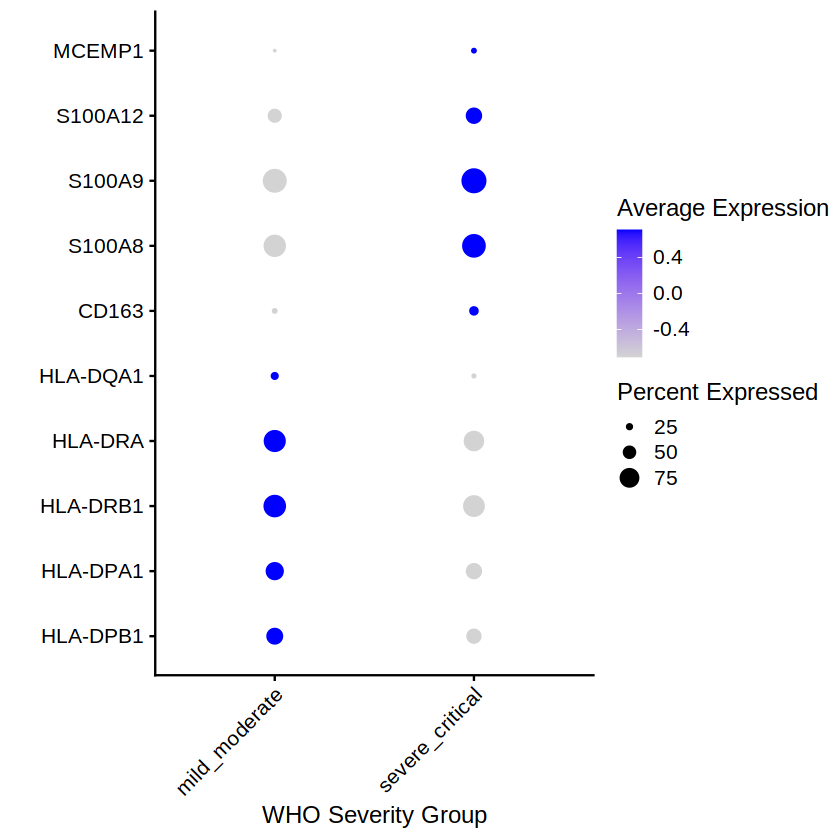

In [76]:
DotPlot(data2,
        features=c("HLA-DPB1","HLA-DPA1","HLA-DRB1","HLA-DRA","HLA-DQA1","CD163","S100A8","S100A9","S100A12","MCEMP1"),
        group.by="WHO_temp_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave("monocytes_severity_dot_plot.pdf",height=6,width=4)


In [55]:
unique(data2@meta.data$level_2)

[1] "CD14mono" "Int.mono" "CD16mono"

In [56]:
#add new group
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="mild_moderate" & data2@meta.data$level_2=="CD14mono", "level_2_severity"]<-"CD14mono_mild_moderate"
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="severe_critical" & data2@meta.data$level_2=="CD14mono", "level_2_severity"]<-"CD14mono_severe_critical"
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="mild_moderate" & data2@meta.data$level_2=="CD16mono", "level_2_severity"]<-"CD16mono_mild_moderate"
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="severe_critical" & data2@meta.data$level_2=="CD16mono", "level_2_severity"]<-"CD16mono_severe_critical"
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="mild_moderate" & data2@meta.data$level_2=="Int.mono", "level_2_severity"]<-"Int.mono_mild_moderate"
data2@meta.data[data2@meta.data$WHO_temp_severity_group=="severe_critical" & data2@meta.data$level_2=="Int.mono", "level_2_severity"]<-"Int.mono_severe_critical"



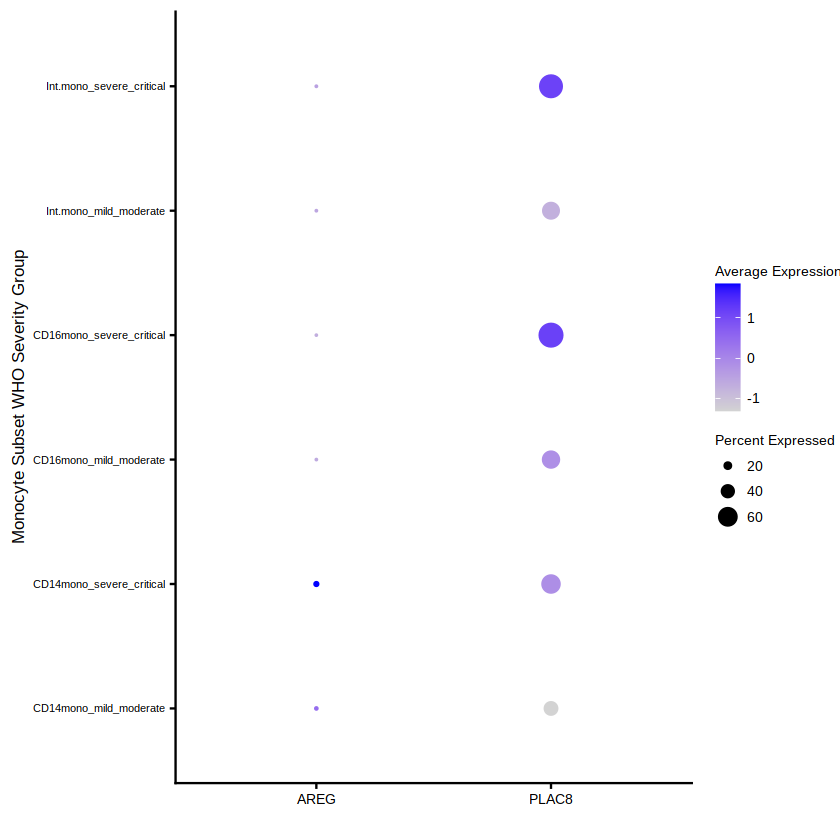

In [57]:
DotPlot(data2,
        features=c("AREG","PLAC8"),
        group.by="level_2_severity") +
#coord_flip() #+
ylab("Monocyte Subset WHO Severity Group") +
xlab("") +
theme(axis.text.y = element_text(size=6),
     axis.text.x = element_text(size=8),
     axis.title = element_text(size=10),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("monocytes_subset_severity_dot_plot.pdf",height=4,width=3)


In [71]:
data3<-subset(data2,subset=level_2=="CD14mono")

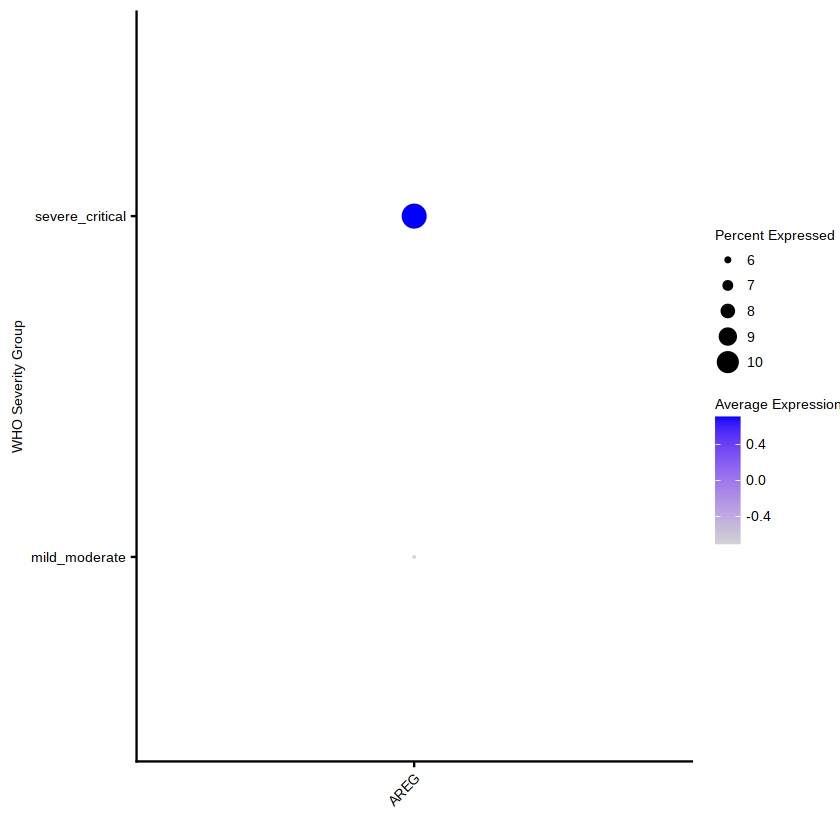

In [82]:
DotPlot(data3,
        features=c("AREG"),
        group.by="WHO_temp_severity_group") +
#coord_flip() +
ylab("WHO Severity Group") +
xlab("") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8),
     axis.text.y = element_text(size=8),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_AREG_severity_dot_plot.pdf",height=4,width=3)

In [66]:
unique(data2@meta.data$level_2)

[1] "CD14mono" "Int.mono" "CD16mono"

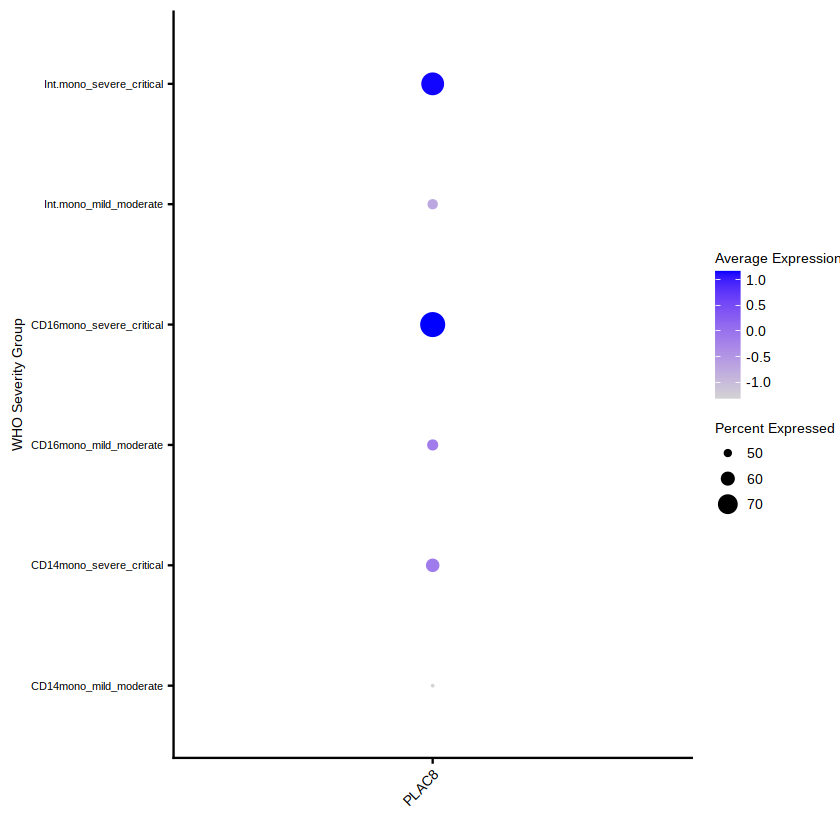

In [94]:
DotPlot(data2,
        features=c("PLAC8"),
        group.by="level_2_severity") +
#coord_flip() +
ylab("WHO Severity Group") +
xlab("") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8),
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("monocyte_subet_PLAC8_severity_dot_plot.pdf",height=4,width=4)

In [ ]:
################
# Severity Cell Proportion bar chart
################ 

In [8]:
data@meta.data[!is.na(data@meta.data$WHO_temp_severity) & data@meta.data$WHO_temp_severity=="mild", "WHO_temp_severity_group"]<-"mild_moderate"
data@meta.data[!is.na(data@meta.data$WHO_temp_severity) & data@meta.data$WHO_temp_severity=="moderate", "WHO_temp_severity_group"]<-"mild_moderate"
data@meta.data[!is.na(data@meta.data$WHO_temp_severity) & data@meta.data$WHO_temp_severity=="severe", "WHO_temp_severity_group"]<-"severe_critical"
data@meta.data[!is.na(data@meta.data$WHO_temp_severity) & data@meta.data$WHO_temp_severity=="critical", "WHO_temp_severity_group"]<-"severe_critical"
data@meta.data[is.na(data@meta.data$WHO_temp_severity), "WHO_temp_severity_group"]<-"NA"

In [9]:
data1<-subset(data,subset=WHO_temp_severity_group!="NA")

In [10]:
tmp<-data.frame(table(data1@meta.data$level_2,data1@meta.data$sample_id))

In [11]:
head(tmp)

,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,ASDC,C101_060121,0
2,B_ASC_dividing,C101_060121,0
3,B_ASC_IgA,C101_060121,0
4,B_ASC_IgG,C101_060121,0
5,B_ASC_IgM,C101_060121,0
6,B_ASC_other,C101_060121,0


In [12]:
names(tmp)<-c("cell_type","sample_id","cell_count")
head(tmp)
dim(tmp)


,cell_type,sample_id,cell_count
,<fct>,<fct>,<int>
1,ASDC,C101_060121,0
2,B_ASC_dividing,C101_060121,0
3,B_ASC_IgA,C101_060121,0
4,B_ASC_IgG,C101_060121,0
5,B_ASC_IgM,C101_060121,0
6,B_ASC_other,C101_060121,0


[1] 4900    3

In [13]:
ss<-data1@meta.data[,c("sample_id","WHO_temp_severity_group")] %>%distinct(sample_id,WHO_temp_severity_group)
head(ss)
dim(ss)


,sample_id,WHO_temp_severity_group
,<chr>,<chr>
UK-CIC10689738+UK-CIC10690026_AAACCTGGTTGAACTC-1,C123_0505,mild_moderate
UK-CIC10689740+UK-CIC10690028_AAACCTGAGCTAACTC-1,C40_0105,severe_critical
UK-CIC10689740+UK-CIC10690028_AAACCTGAGGTGCTTT-1,C42_1504,mild_moderate
UK-CIC10689742+UK-CIC10690030_AAACCTGAGCGTAATA-1,C123_2404,severe_critical
UK-CIC10689742+UK-CIC10690030_AAACCTGCAATAGCGG-1,C124_0105,mild_moderate
UK-CIC10689744+UK-CIC10690032_AAACCTGAGCCACCTG-1,C124_2404,mild_moderate


[1] 140   2

In [14]:
tmp<-merge(tmp,ss,by="sample_id",all=TRUE)

head(tmp)
dim(tmp)


,sample_id,cell_type,cell_count,WHO_temp_severity_group
,<fct>,<fct>,<int>,<chr>
1,C101_060121,ASDC,0,severe_critical
2,C101_060121,B_ASC_dividing,0,severe_critical
3,C101_060121,B_ASC_IgA,0,severe_critical
4,C101_060121,B_ASC_IgG,0,severe_critical
5,C101_060121,B_ASC_IgM,0,severe_critical
6,C101_060121,B_ASC_other,0,severe_critical


[1] 4900    4

In [15]:
tmp<-tmp %>% 
    group_by(sample_id) %>%
    mutate(sample_total=sum(cell_count)) %>%
    ungroup() %>%
    mutate(prop=cell_count/sample_total) %>%
    group_by(WHO_temp_severity_group,cell_type) %>%
    mutate(mean_prop=mean(prop))

In [16]:
tmp2<-tmp %>% distinct(cell_type,WHO_temp_severity_group,mean_prop)
head(tmp2)
dim(tmp2)

cell_type,WHO_temp_severity_group,mean_prop
<fct>,<chr>,<dbl>
ASDC,severe_critical,0.0001675419
B_ASC_dividing,severe_critical,0.0114257741
B_ASC_IgA,severe_critical,0.0167164373
B_ASC_IgG,severe_critical,0.0083050348
B_ASC_IgM,severe_critical,0.0032525862
B_ASC_other,severe_critical,0.0001336857


[1] 70  3

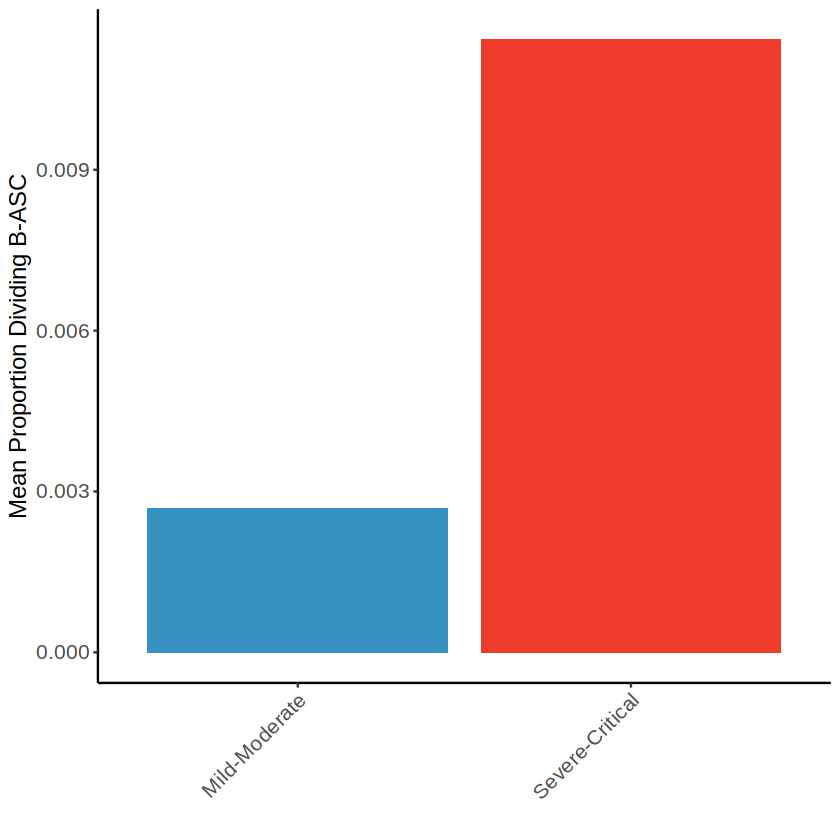

In [33]:
ggplot(tmp2 %>% filter(cell_type=="B_ASC_dividing"),aes(x=WHO_temp_severity_group,y=mean_prop,fill=WHO_temp_severity_group))+
    geom_bar(stat="identity",position="stack")+
    scale_fill_manual(values=c("#3690c0","#ef3b2c"))+
    scale_x_discrete(labels=c("mild_moderate" = "Mild-Moderate", "severe_critical" = "Severe-Critical")) +
    ylab("Mean Proportion Dividing B-ASC")+
    xlab("")+
    theme_classic()+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=12),
         axis.text.y = element_text(size=12),
         axis.title=element_text(size=14),
         legend.position="none")
ggsave("B_ASC_dividing.pdf",height=5,width=3)

In [6]:
suppressPackageStartupMessages(library(msigdbr))

In [8]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [9]:
genes<-genelists$KEGG_AUTOIMMUNE_THYROID_DISEASE

In [11]:
data@meta.data[!is.na(data@meta.data$WHO_severity) & data@meta.data$WHO_tseverity=="mild", "WHO_severity_group"]<-"mild_moderate"
data@meta.data[!is.na(data@meta.data$WHO_severity) & data@meta.data$WHO_severity=="moderate", "WHO_severity_group"]<-"mild_moderate"
data@meta.data[!is.na(data@meta.data$WHO_severity) & data@meta.data$WHO_severity=="severe", "WHO_severity_group"]<-"severe_critical"
data@meta.data[!is.na(data@meta.data$WHO_severity) & data@meta.data$WHO_severity=="critical", "WHO_severity_group"]<-"severe_critical"
data@meta.data[is.na(data@meta.data$WHO_severity), "WHO_severity_group"]<-"NA"



In [12]:
"time_from_infection"%in%names(data@meta.data)

[1] FALSE

In [13]:
# calculate days to sampling, days to admission, days to first symptoms, days to discharge from positive swab
tmp<-data@meta.data
tmp$sample_date<-as.Date(tmp$sample_date,format('%d/%m/%Y'))


In [14]:

tmp$date_first_symptoms<-as.Date(tmp$date_first_symptoms,format('%d/%m/%Y'))
tmp$date_positive_swab<-as.Date(tmp$date_positive_swab,format('%d/%m/%Y'))


In [16]:
time_from_first_symptoms<-tmp$sample_date - tmp$date_first_symptoms
time_from_positive_swab<-tmp$sample_date - tmp$date_positive_swab

In [18]:
days_from_first_symptoms<-time_from_first_symptoms
days_from_positive_swab<-time_from_positive_swab


In [19]:
days_from_first_symptoms[is.na(days_from_first_symptoms)]<-0
days_from_positive_swab[is.na(days_from_positive_swab)]<-0


In [21]:
min(days_from_first_symptoms)
min(days_from_positive_swab)

Time difference of -9 days

Time difference of 0 days

In [22]:
days_from_infection<-c()
for(i in 1:length(days_from_first_symptoms)){
    a<-max(days_from_first_symptoms[i], days_from_positive_swab[i])
    days_from_infection<-c(days_from_infection,a)
}


In [24]:

data@meta.data$time_from_first_symptoms<-days_from_first_symptoms
data@meta.data$time_from_positive_swab<-days_from_positive_swab
data@meta.data$time_from_infection<-days_from_infection


In [26]:
min_cells<-10
nCells <- table(data@meta.data$sample_id)
rmSamples <- names(nCells[nCells < min_cells])

In [28]:
"time_from_infection"%in%names(data@meta.data)

[1] TRUE

In [29]:
data1<-subset(data,subset=level_2=="CD14mono" & WHO_severity_group!="NA" & time_from_infection <= 21 & sample_id!="C168_260121")


In [30]:
# need to to add time somehow  bin 

In [31]:
order(as.numeric(unique(data1@meta.data$time_from_infection)))

[1]  2 19 16 10 13  3 12  6  9 18  5 15  7  4 17  1 11 14  8

In [48]:
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==1, "severity_time"]<-"mild_moderate_1"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==2, "severity_time"]<-"mild_moderate_2"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==3, "severity_time"]<-"mild_moderate_3"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==4, "severity_time"]<-"mild_moderate_4"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==5, "severity_time"]<-"mild_moderate_5"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==6, "severity_time"]<-"mild_moderate_6"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==7, "severity_time"]<-"mild_moderate_7"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==8, "severity_time"]<-"mild_moderate_8"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==9, "severity_time"]<-"mild_moderate_9"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==10, "severity_time"]<-"mild_moderate_10"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==11, "severity_time"]<-"mild_moderate_11"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==12, "severity_time"]<-"mild_moderate_12"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==13, "severity_time"]<-"mild_moderate_13"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==14, "severity_time"]<-"mild_moderate_14"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==15, "severity_time"]<-"mild_moderate_15"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==16, "severity_time"]<-"mild_moderate_16"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==17, "severity_time"]<-"mild_moderate_17"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==18, "severity_time"]<-"mild_moderate_18"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==19, "severity_time"]<-"mild_moderate_19"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==20, "severity_time"]<-"mild_moderate_20"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection==21, "severity_time"]<-"mild_moderate_21"

data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==1, "severity_time"]<-"severe_critical_1"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==2, "severity_time"]<-"severe_critical_2"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==3, "severity_time"]<-"severe_critical_3"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==4, "severity_time"]<-"severe_critical_4"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==5, "severity_time"]<-"severe_critical_5"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==6, "severity_time"]<-"severe_critical_6"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==7, "severity_time"]<-"severe_critical_7"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==8, "severity_time"]<-"severe_critical_8"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==9, "severity_time"]<-"severe_critical_9"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==10, "severity_time"]<-"severe_critical_10"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==11, "severity_time"]<-"severe_critical_11"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==12, "severity_time"]<-"severe_critical_12"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==13, "severity_time"]<-"severe_critical_13"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==14, "severity_time"]<-"severe_critical_14"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==15, "severity_time"]<-"severe_critical_15"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==16, "severity_time"]<-"severe_critical_16"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==17, "severity_time"]<-"severe_critical_17"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==18, "severity_time"]<-"severe_critical_18"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==19, "severity_time"]<-"severe_critical_19"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==20, "severity_time"]<-"severe_critical_20"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection==21, "severity_time"]<-"severe_critical_21"




data1@meta.data[is.na(data1@meta.data$WHO_severity_group), "severity_time"]<-"NA"


In [49]:
table(data1@meta.data$severity_time,useNA="always")


   mild_moderate_1    mild_moderate_2    mild_moderate_3    mild_moderate_4 
                 0                 47                  0                  0 
   mild_moderate_5    mild_moderate_6    mild_moderate_7    mild_moderate_8 
               104                 99                645                  2 
   mild_moderate_9   mild_moderate_10   mild_moderate_11   mild_moderate_12 
               173               1159                  0                567 
  mild_moderate_13   mild_moderate_14   mild_moderate_15   mild_moderate_16 
               853               1962                  0                330 
  mild_moderate_17   mild_moderate_18   mild_moderate_19   mild_moderate_20 
              1446                  0                184                915 
  mild_moderate_21  severe_critical_1  severe_critical_2  severe_critical_3 
               319                  0               1211                335 
 severe_critical_4  severe_critical_5  severe_critical_6  severe_critical_7

In [50]:
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection>=1 & data1@meta.data$time_from_infection<=5, "severity_time_bin"]<-"mild_moderate_1_5"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection>5 & data1@meta.data$time_from_infection<=10, "severity_time_bin"]<-"mild_moderate_6_10"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection>10 & data1@meta.data$time_from_infection<=15, "severity_time_bin"]<-"mild_moderate_11_15"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="mild_moderate" & data1@meta.data$time_from_infection>15 & data1@meta.data$time_from_infection<=21, "severity_time_bin"]<-"mild_moderate_16_21"

data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection>=1 & data1@meta.data$time_from_infection<=5, "severity_time_bin"]<-"severe_critical_1_5"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection>5 & data1@meta.data$time_from_infection<=10, "severity_time_bin"]<-"severe_critical_6_10"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection>10 & data1@meta.data$time_from_infection<=15, "severity_time_bin"]<-"severe_critical_11_15"
data1@meta.data[!is.na(data1@meta.data$WHO_severity_group) & data1@meta.data$WHO_severity_group=="severe_critical" & data1@meta.data$time_from_infection>15 & data1@meta.data$time_from_infection<=21, "severity_time_bin"]<-"severe_critical_16_21"

data1@meta.data[is.na(data1@meta.data$WHO_severity_group), "severity_time_bin"]<-"NA"


In [51]:
table(data1@meta.data$severity_time_bin,useNA="always")


    mild_moderate_1_5    mild_moderate_6_10   mild_moderate_11_15 
                  151                  2078                  3382 
  mild_moderate_16_21   severe_critical_1_5  severe_critical_6_10 
                 3194                  1811                  2496 
severe_critical_11_15 severe_critical_16_21                  <NA> 
                 4063                  4817                     0 

In [52]:
genes<-genelists$KEGG_ALLOGRAFT_REJECTION

In [53]:
unique(genes[genes%in%rownames(data1)])

[1] "CD28"     "CD40"     "CD40LG"   "CD80"     "CD86"     "FAS"     
 [7] "FASLG"    "GZMB"     "HLA-A"    "HLA-B"    "HLA-C"    "HLA-DMA" 
[13] "HLA-DMB"  "HLA-DOA"  "HLA-DOB"  "HLA-DPA1" "HLA-DPB1" "HLA-DQA1"
[19] "HLA-DQA2" "HLA-DQB1" "HLA-DRA"  "HLA-DRB1" "HLA-DRB5" "HLA-E"   
[25] "HLA-F"    "HLA-G"    "IFNG"     "IL10"     "IL12A"    "IL12B"   
[31] "IL2"      "IL4"      "IL5"      "PRF1"     "TNF"

In [54]:
data1@meta.data$severity_time<-factor(data1@meta.data$severity_time,levels=c(
    "mild_moderate_1",
    
    "mild_moderate_2",
    
    "mild_moderate_3",
    
    "mild_moderate_4",
    
    "mild_moderate_5",
    
    "mild_moderate_6",
    
    "mild_moderate_7",
    
    "mild_moderate_8",
    
    "mild_moderate_9",
   
    "mild_moderate_10",
    
    "mild_moderate_11",
    
    "mild_moderate_12",
   
    "mild_moderate_13",
    
    "mild_moderate_14",
    
    "mild_moderate_15",
    
    "mild_moderate_16",
    
    "mild_moderate_17",
    
    "mild_moderate_18",
    
    "mild_moderate_19",
    
    "mild_moderate_20",
    
    "mild_moderate_21",
    "severe_critical_1",
    "severe_critical_2",
    "severe_critical_3",
    "severe_critical_4",
    "severe_critical_5",
    "severe_critical_6",
    "severe_critical_7",
    "severe_critical_8",
     "severe_critical_9",
    "severe_critical_10",
    "severe_critical_11",
     "severe_critical_12",
    "severe_critical_13",
    "severe_critical_14",
    "severe_critical_15",
    "severe_critical_16",
    "severe_critical_17",
    "severe_critical_18",
    "severe_critical_19",
    "severe_critical_20",
    "severe_critical_21"))

In [55]:
data1@meta.data$severity_time_bin<-factor(data1@meta.data$severity_time_bin,levels=c(
    "mild_moderate_1_5",
    "mild_moderate_6_10",
    "mild_moderate_11_15",
    "mild_moderate_16_21",
    "severe_critical_1_5",
    "severe_critical_6_10",
    "severe_critical_11_15",
    "severe_critical_16_21"
    ))

In [56]:
getwd()

[1] "/rds/general/project/covid19-transcriptome/live/sc_rnaseq/DA"

In [57]:
data1@meta.data[data1@meta.data$time_from_infection>=1 & data1@meta.data$time_from_infection<=5, "time_bin"]<-"1_5"
data1@meta.data[data1@meta.data$time_from_infection>5 & data1@meta.data$time_from_infection<=10, "time_bin"]<-"6_10"
data1@meta.data[data1@meta.data$time_from_infection>10 & data1@meta.data$time_from_infection<=15, "time_bin"]<-"11_15"
data1@meta.data[data1@meta.data$time_from_infection>15 & data1@meta.data$time_from_infection<=21, "time_bin"]<-"16_21"


In [58]:
table(data1@meta.data$time_bin,useNA="always")


  1_5 11_15 16_21  6_10  <NA> 
 1962  7445  8011  4574     0 

In [41]:
#library(scCustomize)
library(dittoSeq)

In [61]:
dittoDotPlot(data1,
        vars=unique(genes[genes%in%rownames(data1)]),
        group.by="time_bin") + #,extra.vars = "WHO_severity_group"
coord_flip() +
facet_grid(~WHO_severity_group) +
ylab("WHO Severity Group") +
xlab("KEGG ALLOGRAFT REJECTION") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))


#test + facet_grid(~WHO_severity_group) 
#ggsave("CD14mono_KEGG_ALLOGRAFT_REJECTION_severity_dot_plot_time_bin.pdf",height=6,width=7)

ERROR while rich displaying an object: Error in `combine_vars()`:
! At least one layer must contain all faceting variables: `WHO_severity_group`.
* Plot is missing `WHO_severity_group`
* Layer 1 is missing `WHO_severity_group`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(

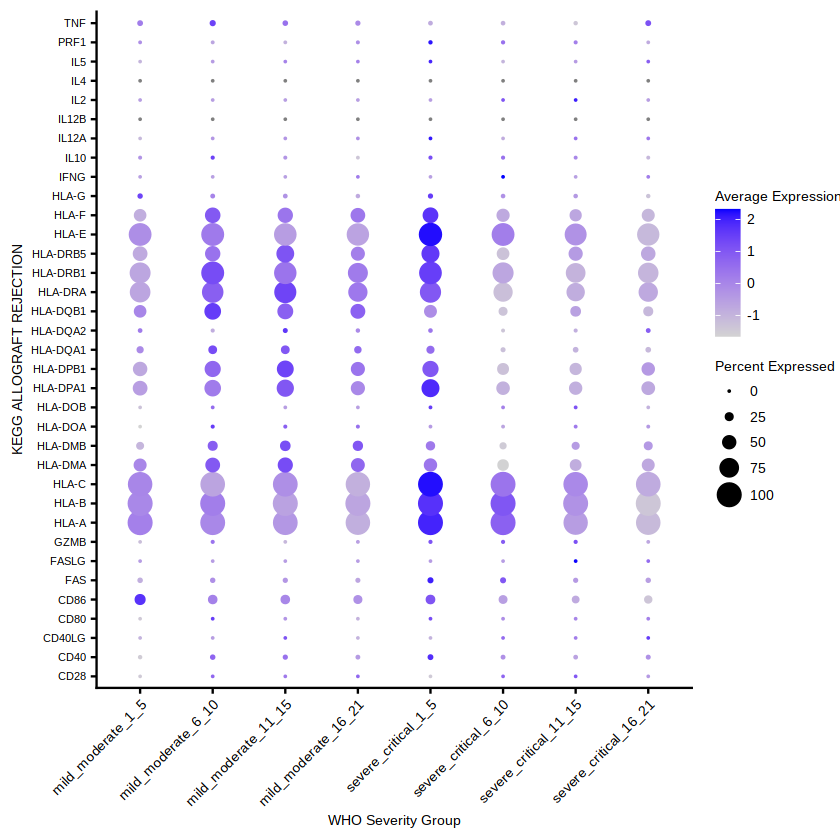

In [42]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="severity_time_bin") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG ALLOGRAFT REJECTION") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_ALLOGRAFT_REJECTION_severity_dot_plot_time_bin.pdf",height=6,width=7)

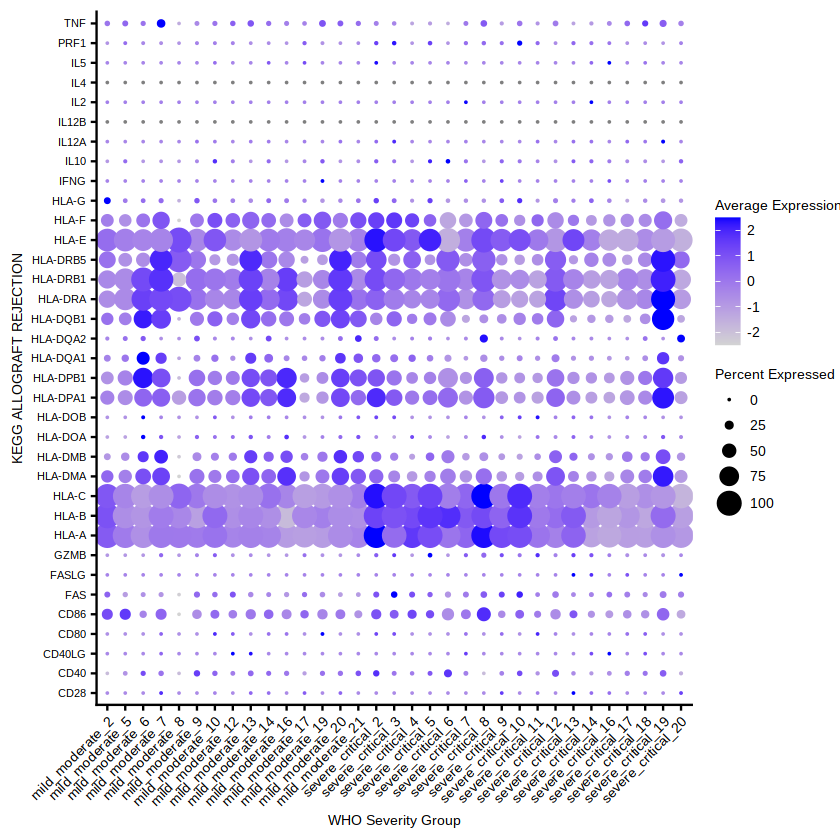

In [46]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="severity_time") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG ALLOGRAFT REJECTION") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_ALLOGRAFT_REJECTION_severity_dot_plot_time.pdf",height=6,width=7)

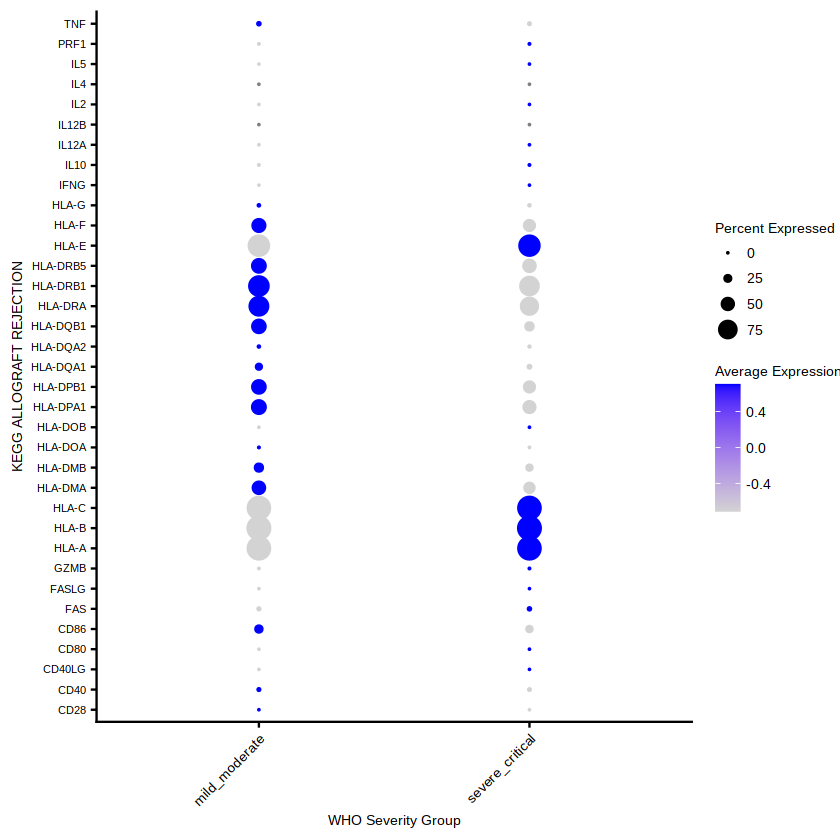

In [67]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG ALLOGRAFT REJECTION") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
#ggsave("CD14mono_KEGG_ALLOGRAFT_REJECTION_severity_dot_plot.pdf",height=6,width=3)

In [69]:
genes<-genelists$KEGG_GRAFT_VERSUS_HOST_DISEASE

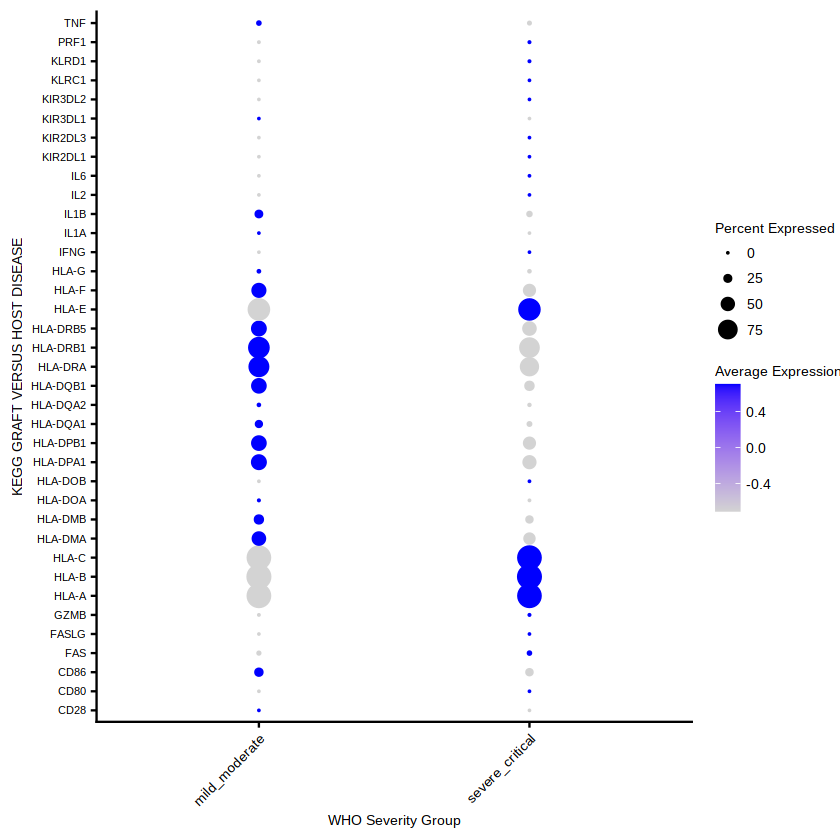

In [70]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG GRAFT VERSUS HOST DISEASE") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_GRAFT_VERSUS_HOST_DISEASE_severity_dot_plot.pdf",height=6,width=3)

In [71]:
genes<-genelists$KEGG_ASTHMA

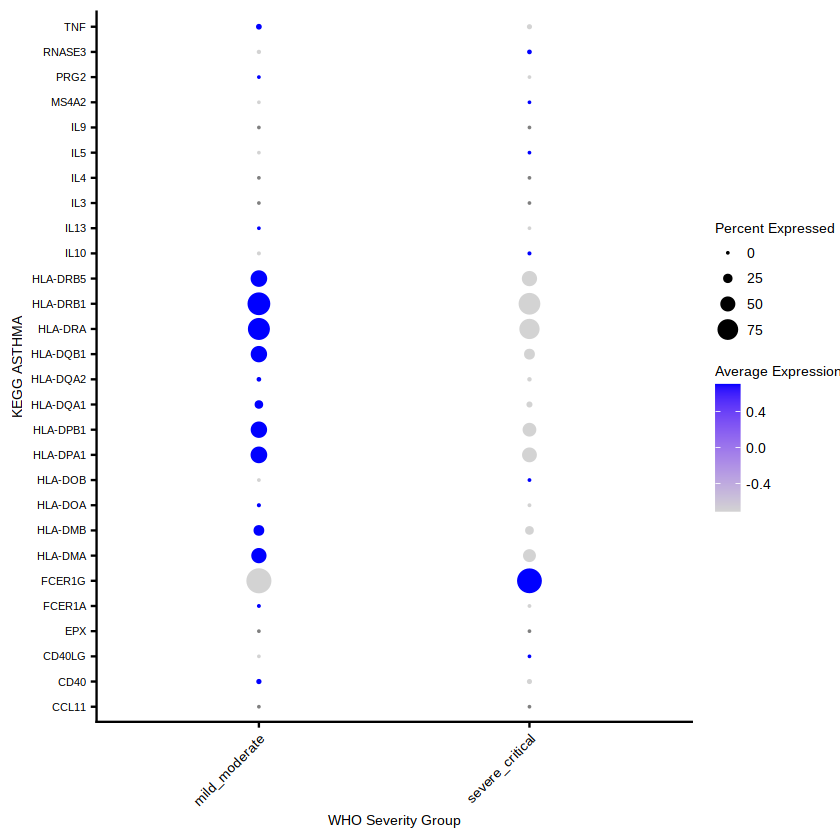

In [72]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG ASTHMA") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_ASTHMA_severity_dot_plot.pdf",height=6,width=3)

In [73]:
genes<-genelists$KEGG_TYPE_I_DIABETES_MELLITUS

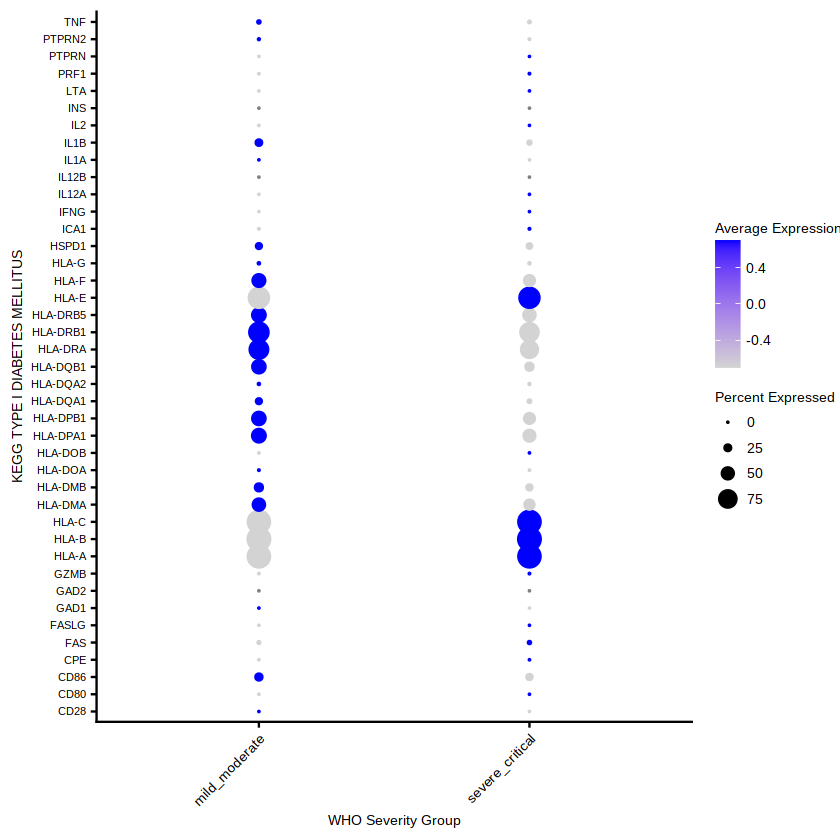

In [74]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG TYPE I DIABETES MELLITUS") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_TYPE_I_DIABETES_MELLITUS_severity_dot_plot.pdf",height=6,width=3)

In [75]:
genes<-genelists$KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS

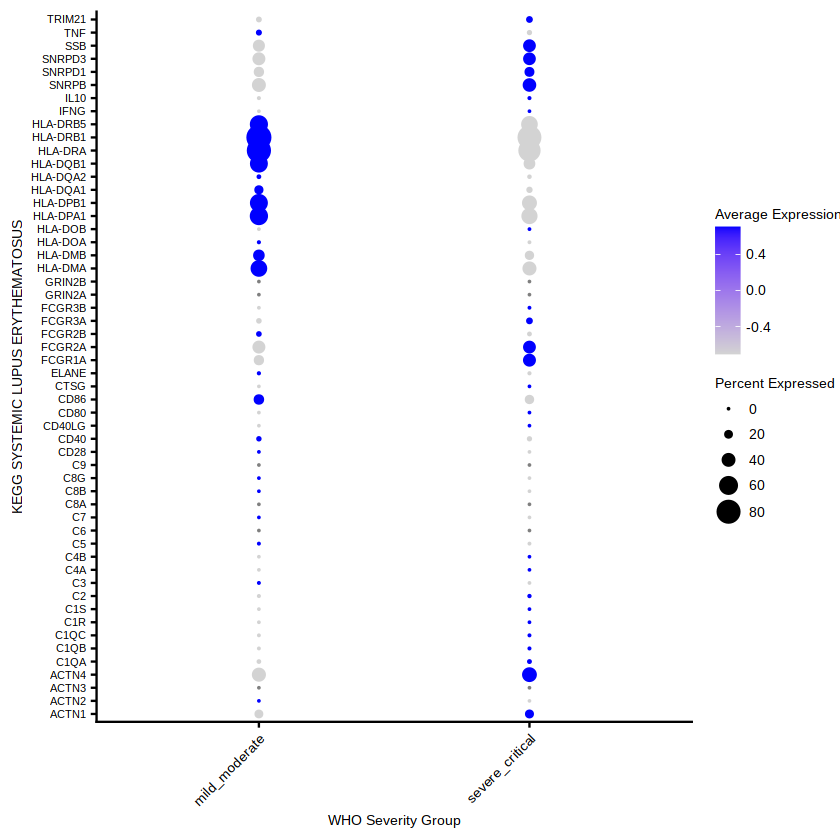

In [76]:
DotPlot(data1,
        features=unique(genes[genes%in%rownames(data1)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG SYSTEMIC LUPUS ERYTHEMATOSUS") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("CD14mono_KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS_severity_dot_plot.pdf",height=6,width=3)

In [77]:
data2<-subset(data,subset=level_1=="B" & WHO_severity_group!="NA" & time_from_infection <= 21 & sample_id!="C168_260121")


In [81]:
genes<-genelists$KEGG_ALLOGRAFT_REJECTION

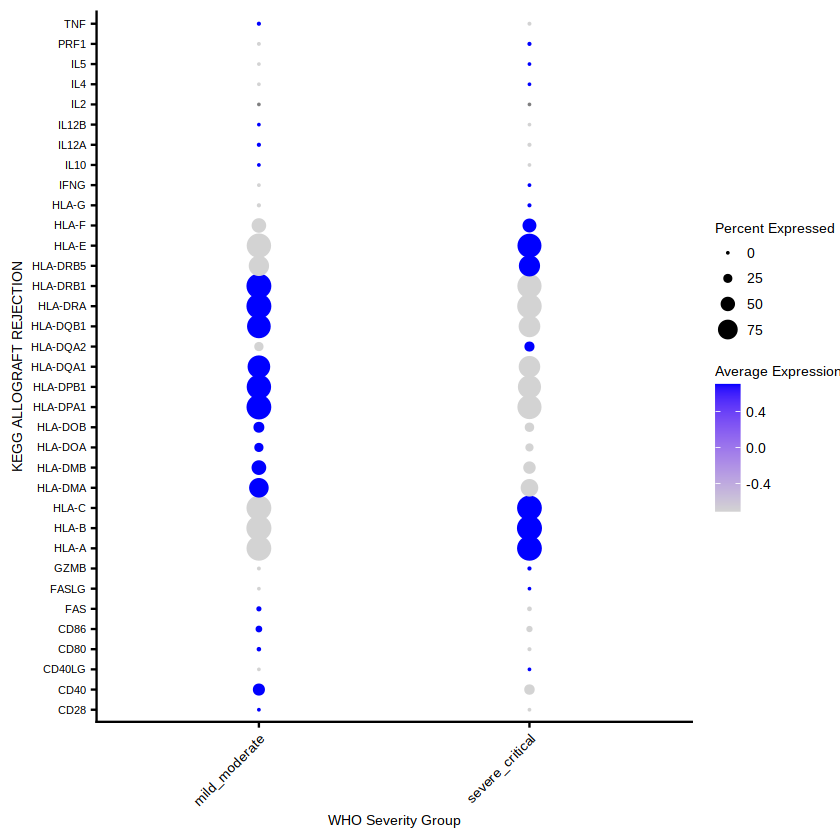

In [82]:
DotPlot(data2,
        features=unique(genes[genes%in%rownames(data2)]),
        group.by="WHO_severity_group") +
coord_flip() +
ylab("WHO Severity Group") +
xlab("KEGG ALLOGRAFT REJECTION") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=8), #
     axis.text.y = element_text(size=6),
     axis.title = element_text(size=8),
     legend.title = element_text(size=8),
     legend.text = element_text(size=8))
ggsave("B_KEGG_ALLOGRAFT_REJECTION_severity_dot_plot.pdf",height=6,width=3)

In [61]:
getwd()

[1] "/rds/general/project/covid19-transcriptome/live/sc_rnaseq/DA"

In [20]:
"WHO_severity"%in%names(data1@meta.data)

[1] TRUE

In [21]:
table(data1@meta.data$WHO_severity_group,useNA="always")


  mild_moderate              NA severe_critical            <NA> 
           8805           19162           13187           16568 